In [1]:
import torch
import torch.nn as nn
from models import GridMLMMelHarm
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_structured_masking

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batchsize = 1
val_dir = '/media/maindisk/maximos/data/hooktheory_all12_train'
tokenizer = CSGridMLMTokenizer(fixed_length=256)
val_dataset = CSGridMLMDataset(val_dir, tokenizer, 512)
valloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False, collate_fn=CSGridMLM_collate_fn)

In [3]:
mask_token_id = tokenizer.mask_token_id
stage = 2
curriculum_type = 'ts_incr'
# curriculum_type = 'random'
# curriculum_progression = 'uniform'
curriculum_progression = 'linear'
stage_aware = True

In [4]:
device_name = 'cuda:1'
if device_name == 'cpu':
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
model = GridMLMMelHarm(
    chord_vocab_size=len(tokenizer.vocab),
    conditioning_dim=16,
    device=device,
    max_stages=6
)
model_path = 'saved_models/' + curriculum_progression + '/' + 'a_'*stage_aware + curriculum_type +  '.pt'
# checkpoint = torch.load(model_path, map_location=device_name, weights_only=True)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GridMLMMelHarm(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (dropout): Dropout(p=0.3, inplace=False)
  (stage_embedding): Embedding(6, 64)
  (stage_proj): Linear(in_features=576, out_features=512, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (d

In [5]:
i = 0
for batch in valloader:
    if i == 3:
        break
    i += 1

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [6]:
melody_grid = batch["pianoroll"].to(device)           # (B, 256, 140)
harmony_gt = batch["input_ids"].to(device)         # (B, 256)
conditioning_vec = batch["time_signature"].to(device)  # (B, C0)

In [7]:
# Apply masking to harmony
harmony_input, harmony_target = apply_structured_masking(
    harmony_gt,
    mask_token_id,
    stage,
    conditioning_vec,
    curriculum_type
)

In [8]:
logits = model(
    conditioning_vec.to(device),
    melody_grid.to(device),
    harmony_input.to(device),
    None if not stage_aware else stage
)

In [9]:
model = GridMLMMelHarm(
    chord_vocab_size=len(tokenizer.vocab),
    conditioning_dim=16,
    device=device,
    max_stages=6
)
model_path = 'saved_models/' + curriculum_progression + '/' + 'a_'*stage_aware + curriculum_type +  '.pt'
# checkpoint = torch.load(model_path, map_location=device_name, weights_only=True)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
print(model.pos_embedding)
model.eval()
model.to(device)
out1 = model(
    conditioning_vec.to(device),
    melody_grid.to(device),
    harmony_input.to(device),
    None if not stage_aware else stage
).detach().cpu()
model = GridMLMMelHarm(
    chord_vocab_size=len(tokenizer.vocab),
    conditioning_dim=16,
    device=device,
    max_stages=6
)
model_path = 'saved_models/' + curriculum_progression + '/' + 'a_'*stage_aware + curriculum_type +  '.pt'
# checkpoint = torch.load(model_path, map_location=device_name, weights_only=True)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
print(model.pos_embedding)
model.eval()
model.to(device)
out2 = model(
    conditioning_vec.to(device),
    melody_grid.to(device),
    harmony_input.to(device),
    None if not stage_aware else stage
).detach().cpu()
print(torch.allclose(out1, out2, atol=1e-6))

Parameter containing:
tensor([[[-1.1610, -0.2017, -0.8392,  ..., -1.0776,  0.9221,  0.6197],
         [ 1.5371, -0.6667, -0.1501,  ..., -0.9258, -0.5859, -0.8516],
         [-0.2464, -1.3558,  0.1046,  ...,  1.0777,  0.8737, -0.0277],
         ...,
         [ 0.5899, -0.4393,  1.0859,  ..., -1.4848,  0.1806,  1.1944],
         [ 0.7616, -1.1875,  1.1939,  ..., -0.9818, -0.3185,  0.5350],
         [ 0.2387,  0.5781, -0.5900,  ..., -0.6317, -0.7230, -1.1771]]],
       device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[[-1.1610, -0.2017, -0.8392,  ..., -1.0776,  0.9221,  0.6197],
         [ 1.5371, -0.6667, -0.1501,  ..., -0.9258, -0.5859, -0.8516],
         [-0.2464, -1.3558,  0.1046,  ...,  1.0777,  0.8737, -0.0277],
         ...,
         [ 0.5899, -0.4393,  1.0859,  ..., -1.4848,  0.1806,  1.1944],
         [ 0.7616, -1.1875,  1.1939,  ..., -0.9818, -0.3185,  0.5350],
         [ 0.2387,  0.5781, -0.5900,  ..., -0.6317, -0.7230, -1.1771]]],
       device='cuda:1', requ

In [18]:
print('pos_embedding' in checkpoint)  # should be True
print(model.state_dict()['pos_embedding'][0, :2, :4])  # small slice to verify
# print(checkpoint.keys())

True
tensor([[-1.1610, -0.2017, -0.8392,  0.2099],
        [ 1.5371, -0.6667, -0.1501,  0.0465]], device='cuda:1')


In [11]:
print(logits.shape)

torch.Size([1, 256, 354])


In [12]:
output_ids = torch.argmax(logits, dim=-1)

output_tokens = []
for i,t in enumerate(output_ids[0].tolist()):
    output_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('output_tokens')
print(output_tokens)

harmony_input_tokens = []
for i,t in enumerate(harmony_input[0].tolist()):
    harmony_input_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
    # if tokenizer.ids_to_tokens[t] != '<mask>':
    #     print('UNMASK:', i)
print('harmony_input_tokens')
print(harmony_input_tokens)

harmony_target_tokens = []
for i,t in enumerate(harmony_target[0].tolist()):
    if t < 0:
        harmony_target_tokens.append( str(i) + ':' + '<mask>' )
    else:
        harmony_target_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_target_tokens')
print(harmony_target_tokens)

harmony_gt_tokens = []
for i,t in enumerate(harmony_gt[0].tolist()):
    harmony_gt_tokens.append( str(i) + ':' + tokenizer.ids_to_tokens[t] )
print('harmony_gt_tokens')
print(harmony_gt_tokens)

# for module in model.modules():
#     if isinstance(module, nn.Dropout):
#         print(f"Dropout p={module.p}, training={module.training}")

output_tokens
['0:A#:maj', '1:A#:maj', '2:A#:maj', '3:A#:maj', '4:A#:maj', '5:A#:maj', '6:A#:maj', '7:A#:maj', '8:A#:maj', '9:A#:maj', '10:A#:maj', '11:A#:maj', '12:A#:maj', '13:A#:maj', '14:A#:maj', '15:A#:maj', '16:A#:maj', '17:A#:maj', '18:A#:maj', '19:A#:maj', '20:A#:maj', '21:A#:maj', '22:A#:maj', '23:A#:maj', '24:A#:maj', '25:A#:maj', '26:A#:maj', '27:A#:maj', '28:A#:maj', '29:A#:maj', '30:A#:maj', '31:A#:maj', '32:A#:maj', '33:A#:maj', '34:A#:maj', '35:A#:maj', '36:A#:maj', '37:A#:maj', '38:A#:maj', '39:A#:maj', '40:A#:maj', '41:A#:maj', '42:A#:maj', '43:A#:maj', '44:A#:maj', '45:A#:maj', '46:A#:maj', '47:A#:maj', '48:A#:maj', '49:A#:maj', '50:A#:maj', '51:A#:maj', '52:A#:maj', '53:A#:maj', '54:A#:maj', '55:A#:maj', '56:A#:maj', '57:A#:maj', '58:A#:maj', '59:A#:maj', '60:A#:maj', '61:A#:maj', '62:A#:maj', '63:A#:maj', '64:A#:maj', '65:A#:maj', '66:A#:maj', '67:A#:maj', '68:A#:maj', '69:A#:maj', '70:A#:maj', '71:A#:maj', '72:A#:maj', '73:A#:maj', '74:A#:maj', '75:A#:maj', '76:A#:

In [13]:
import matplotlib.pyplot as plt

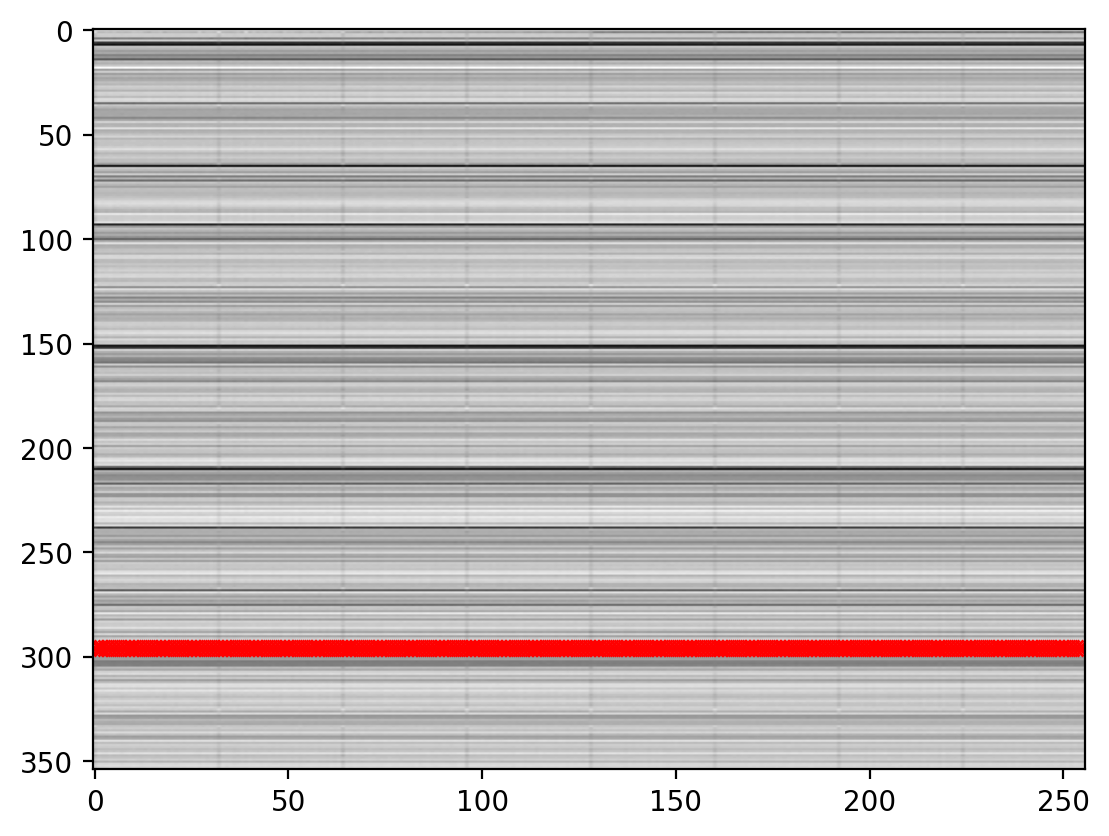

In [14]:
plt.imshow(logits[0,:,:].detach().cpu().numpy().T, aspect='auto', cmap='gray_r',)
plt.plot(output_ids.detach().cpu().numpy().T, 'rx')

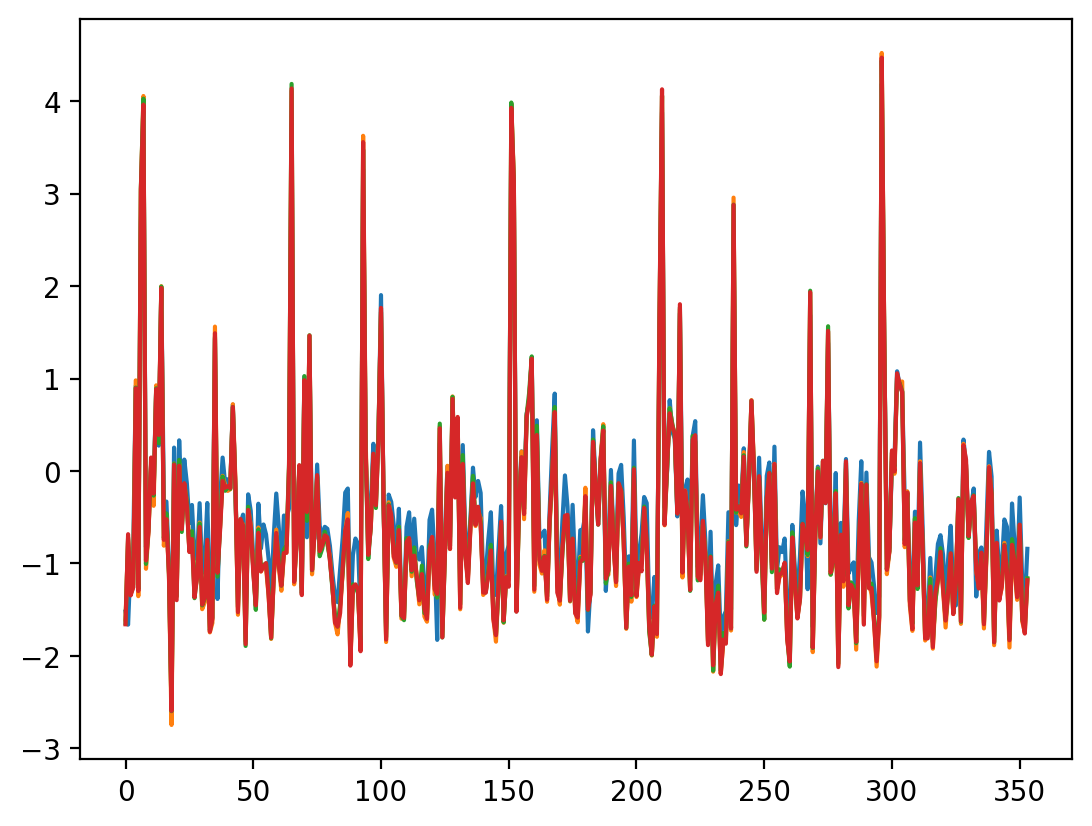

In [15]:
plt.plot(logits[0,0,:].detach().cpu().numpy())
plt.plot(logits[0,1,:].detach().cpu().numpy())
plt.plot(logits[0,2,:].detach().cpu().numpy())
plt.plot(logits[0,6,:].detach().cpu().numpy())

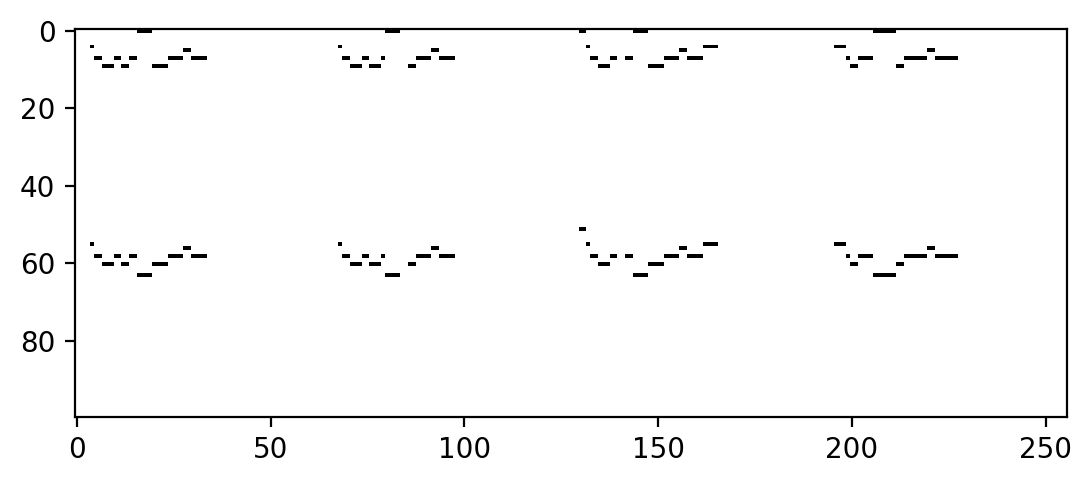

In [16]:
plt.imshow(melody_grid[0,:,:].detach().cpu().numpy().T, cmap='gray_r')

In [17]:
x = logits[0,0,:].argsort(descending=True)
for i in x:
    print( tokenizer.ids_to_tokens[int(i)])

A#:maj
C:min
G:min
D:min
F:maj
D#:maj
F:min
C:maj
G#:maj
C:min7
D#:maj7
G:min7
A:min
C#:maj
A:min7
A#:min
D:min7
G:maj
F:min7
A#:7
D:7
A#:maj7
<nc>
C:7
A#:min7
F:min11
G:sus4
F:maj7
C#:maj7
E:7
G#:maj7
F:7
F:maj6
G:maj9
E:min7
F#:maj7
F#:dim
G:sus2
G:hdim7
D#:7
G:7
B:dim
C:min9
F#:maj13
A#:min9
E:min
D#:sus4
E:maj6
C:maj7
G#:9
C:hdim7
G#:sus4
F:9
F:sus4
B:hdim7
D#:min
C#:dim
G#:maj6
A:min9
F#:7
A#:sus2
C:min11
A:13
A#:sus4
G#:maj9
D:min6
F#:maj9
B:sus4
E:sus4
C:sus4
A:sus4
E:maj9
A:7
F#:maj6
G:dim
D:sus4
A:5
A:min6
F#:hdim7
F:13
G#:hdim7
B:maj9
C#:sus2
G:min6
G#:min7
G#:7
F#:sus4
E:9
D#:sus2
C:11
C#:sus4
G#:aug
C#:7
B:maj7
D:5
G:maj6
E:maj7
C:sus2
C#:min7
G#:7(#11)
A#:maj6
D:1
E:min11
C#
C#:hdim7
D#:maj6
G:min11
E:min9
F#:5
B:7(b9)
F:dim
F:sus2
C#:aug
A#:minmaj7
C:maj6
D#:min6
G#:dim
C:7(#9)
F#
C:5
A:maj7
D#:min7
C:minmaj7
B:1
C#:min11
F
C:min13
C:9
E:7(b9)
F:1
B:7
G:aug
D#:dim
D:maj
D#:maj9
D#:7(#11)
C#:maj9
C:dim
F:min9
A#:hdim7
G:7(#11)
E:13
D#:11
F#:maj
C#:min6
C#:7(#11)
G#:7(b13)
